# RNN 을 이용한 전력사용 예측
- 단변수 예측
- 멀티 스텝 예측
- 벡터 출력 모델
- 시퀀스 투 시퀀스 모델

In [1]:
# GPU 사용 확인
import tensorflow as tf
from tensorflow import keras
if tf.config.list_physical_devices('GPU'): 
    print("GPU 사용중입니다")
else:
    print("런타임-런타임유형변경-GPU 설정이 필요합니다")

GPU 사용중입니다


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.metrics import r2_score, mean_squared_error

plt.rc('figure', figsize=(8,2))

# 기본 RNN 모델
- 전력 사용 데이터 다운로드

In [3]:
!curl -L https://bit.ly/2Fj0z2P -o energy.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   151  100   151    0     0   1006      0 --:--:-- --:--:-- --:--:--  1006
100   141    0   141    0     0    370      0 --:--:-- --:--:-- --:--:--   370
100   320  100   320    0     0    380      0 --:--:-- --:--:-- --:--:--     0
100  957k  100  957k    0     0   688k      0  0:00:01  0:00:01 --:--:--  688k


In [4]:
energy = pd.read_csv('energy.csv', parse_dates=['timestamp']) 
energy[:3]

,timestamp,load,temp
0,2012-01-01 00:00:00,2698.0,32.000000
1,2012-01-01 01:00:00,2558.0,32.666667
2,2012-01-01 02:00:00,2444.0,30.000000


In [5]:
energy["timestamp"].min(), energy["timestamp"].max(), len(energy)

(Timestamp('2012-01-01 00:00:00'), Timestamp('2014-12-31 23:00:00'), 26304)

In [6]:
power = energy["load"].values

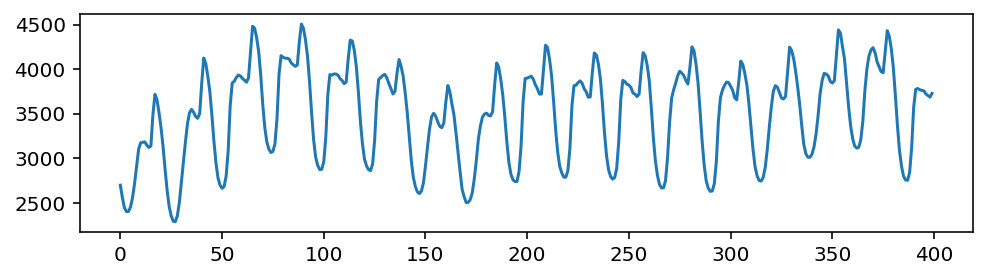

In [7]:
plt.plot(power[:400])

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_sc = scaler.fit_transform(power.reshape(-1,1))
train_sc =  x_sc[:2000]
test_sc =  x_sc[2000:3000]

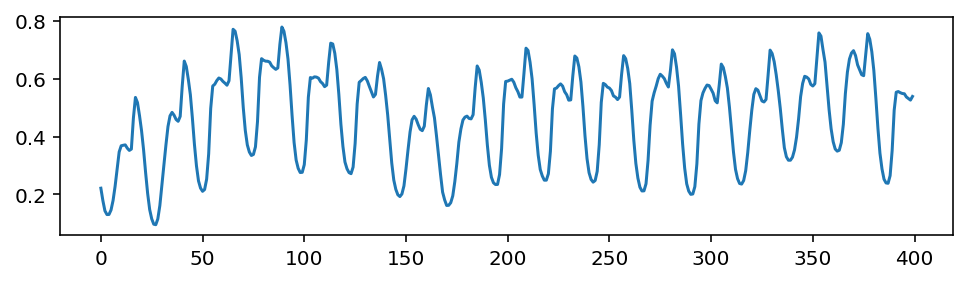

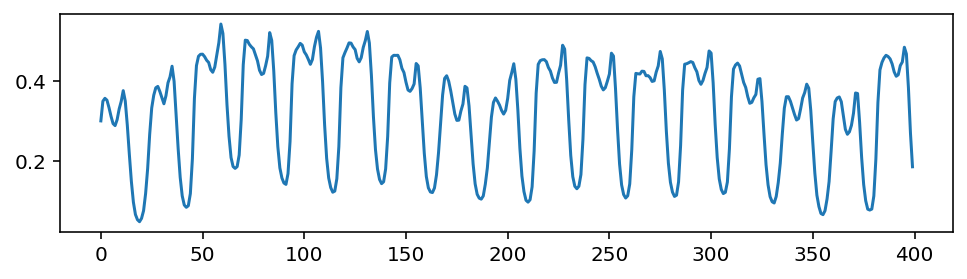

In [17]:
plt.plot(train_sc[:400])
plt.show()
plt.plot(test_sc[:400])

In [18]:
def get_xy(sequence, n_steps_in, n_steps_out):
  x, y = [],[]
  for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    if out_end_ix > len(sequence):
        break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    x.append(seq_x)
    y.append(seq_y)
  return np.array(x), np.array(y) 

In [19]:
x = np.arange(10);x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [20]:
get_xy(x,5,3)

(array([[0, 1, 2, 3, 4],
        [1, 2, 3, 4, 5],
        [2, 3, 4, 5, 6]]), array([[5, 6, 7],
        [6, 7, 8],
        [7, 8, 9]]))

## 데이터 구조
- (-1, 51) 구조의 시계열 데이터를 생성하여
- 앞의 50 컬럼을 X로, 마지막 컬럼을 y로 사용

In [21]:
n_steps = 50

X_train, y_train = get_xy(train_sc, n_steps, 1)
X_valid, y_valid = get_xy(test_sc, n_steps, 1)

In [22]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1950, 50, 1), (1950, 1, 1), (950, 50, 1), (950, 1, 1))

In [23]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "rx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "bo")
    if x_label:
        plt.xlabel(x_label, fontsize=12)
    if y_label:
        plt.ylabel(y_label, fontsize=12)
#     plt.hlines(0, 0, 51, linewidth=1)
    plt.axis([0, n_steps + 1, 0, 1])

In [24]:
X_valid[0, :, 0]

array([0.30046225, 0.34946071, 0.35654854, 0.35192604, 0.33343606,
       0.31186441, 0.29368259, 0.28875193, 0.30354391, 0.33004622,
       0.34884438, 0.37565485, 0.34976888, 0.28998459, 0.21756549,
       0.15007704, 0.09830508, 0.06779661, 0.05485362, 0.04992296,
       0.05824345, 0.07734977, 0.11987673, 0.18181818, 0.26687211,
       0.33251156, 0.3642527 , 0.38274268, 0.38613251, 0.37349769,
       0.35808937, 0.34298921, 0.36302003, 0.39506934, 0.40986133,
       0.43636364, 0.39876733, 0.31617874, 0.23143297, 0.16024653,
       0.11402157, 0.09152542, 0.08567026, 0.08967643, 0.11987673,
       0.20616333, 0.3568567 , 0.43790447, 0.46101695, 0.46594761])

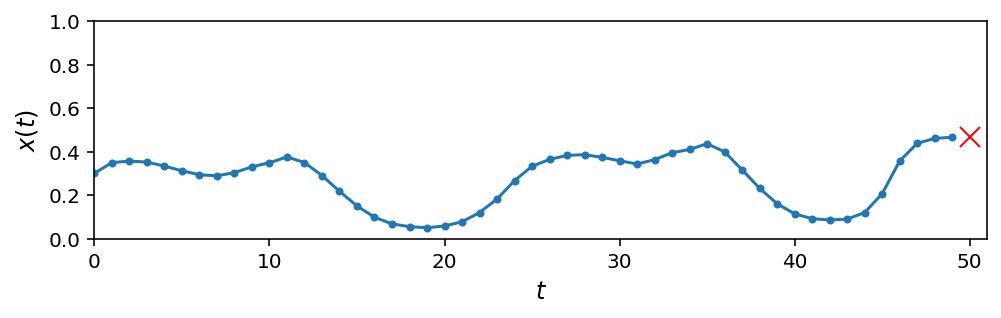

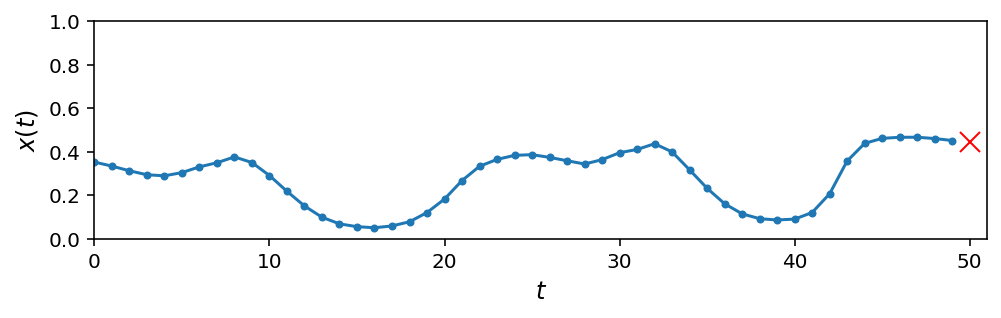

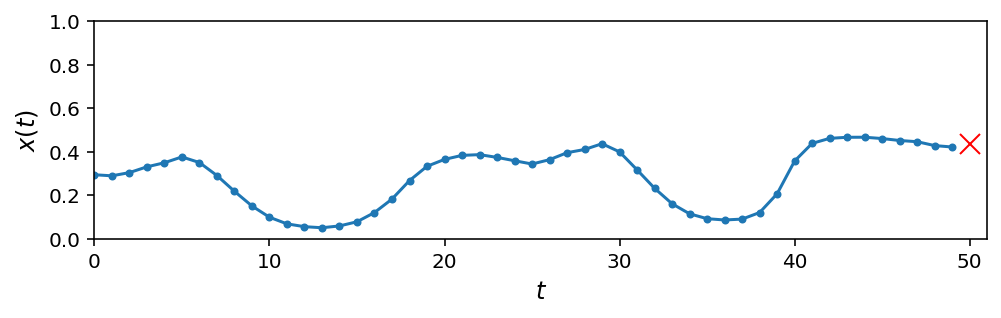

In [25]:
# 검증 시계열 데이터 확인
for sample in range(0,9,3):
    plot_series(X_valid[sample, :, 0], y_valid[sample, 0])
    plt.show()

## 베이스라인 모델 (persistent 모델)

In [26]:
def rmse_r2(y_valid, y_pred):
  print("RMSE =", mean_squared_error(y_valid, y_pred, squared=False).round(4))
  print("R-Squares =", r2_score(y_valid, y_pred).round(4))

In [27]:
y_pred = X_valid[:, -1,0]
rmse_r2(y_valid[:,:,0], y_pred)

RMSE = 0.0467
R-Squares = 0.8737


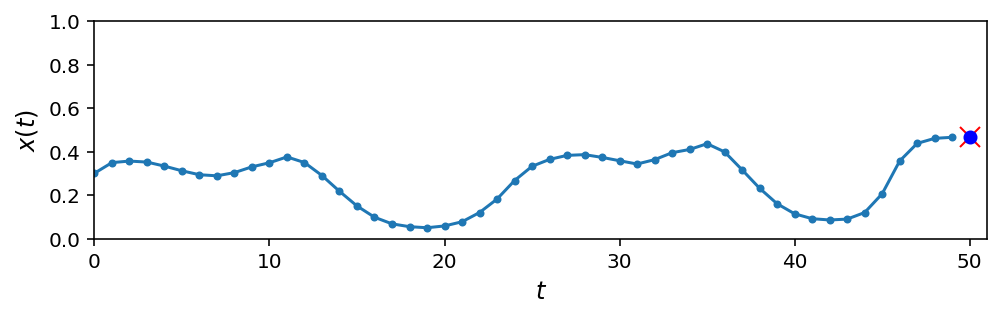

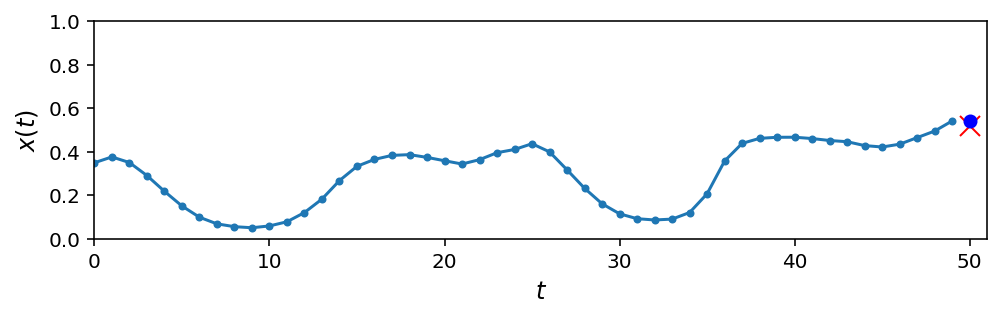

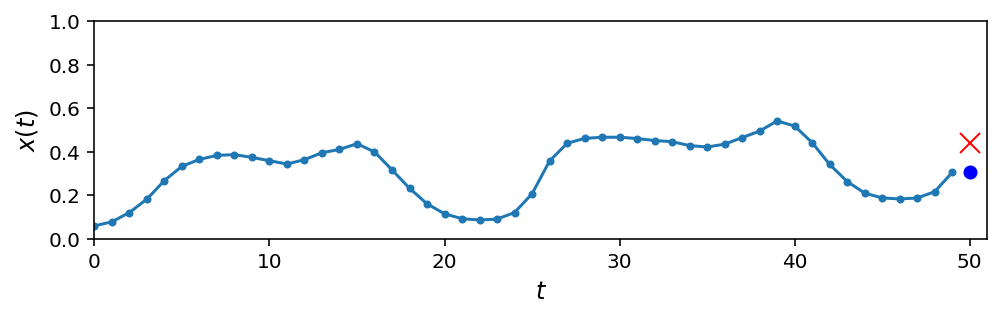

In [28]:
for sample in range(0,30,10):
  plot_series(X_valid[sample, :, 0], y_valid[sample, 0], y_pred[sample])
  plt.show()

## 선형 예측

In [29]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
61/61 [==============================] - 3s 4ms/step - loss: 0.0743 - val_loss: 0.0402
Epoch 2/10
61/61 [==============================] - 0s 3ms/step - loss: 0.0411 - val_loss: 0.0278
Epoch 3/10
61/61 [==============================] - 0s 3ms/step - loss: 0.0287 - val_loss: 0.0196
Epoch 4/10
61/61 [==============================] - 0s 3ms/step - loss: 0.0207 - val_loss: 0.0143
Epoch 5/10
61/61 [==============================] - 0s 2ms/step - loss: 0.0155 - val_loss: 0.0111
Epoch 6/10
61/61 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0087
Epoch 7/10
61/61 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0073
Epoch 8/10
61/61 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0059
Epoch 9/10
61/61 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0051
Epoch 10/10
61/61 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0044


In [30]:
y_pred = model.predict(X_valid)
rmse_r2(y_valid[:,:,0], y_pred)

RMSE = 0.0661
R-Squares = 0.7471


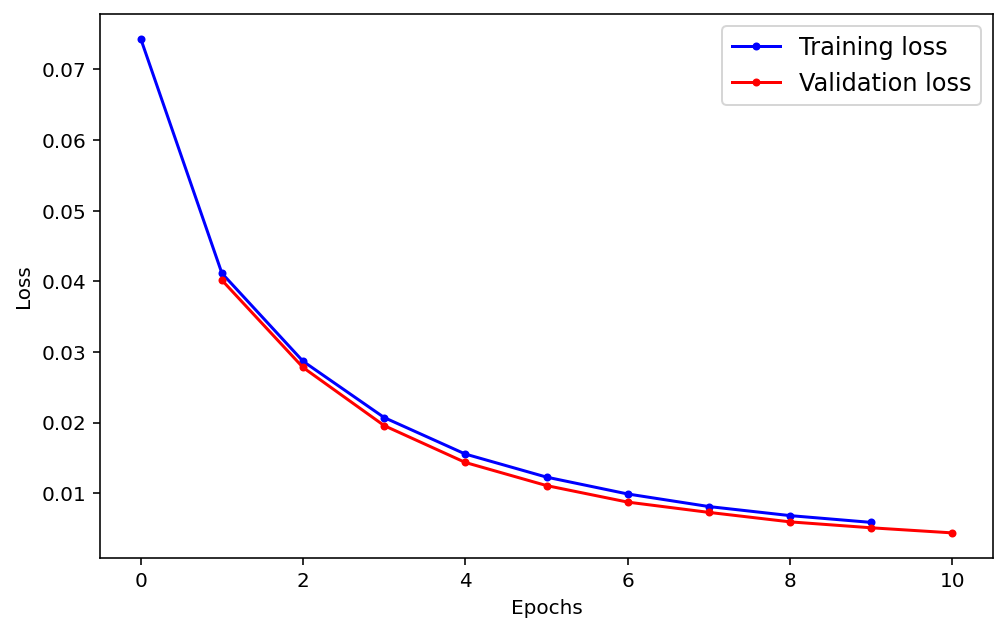

In [34]:
def plot_learning_curves(loss, val_loss):
    plt.figure(figsize=(8,5))
    plt.plot(loss, "b.-", label="Training loss")
    plt.plot(range(1,len(val_loss)+1), val_loss, "r.-", label="Validation loss")
    plt.legend(fontsize=12)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

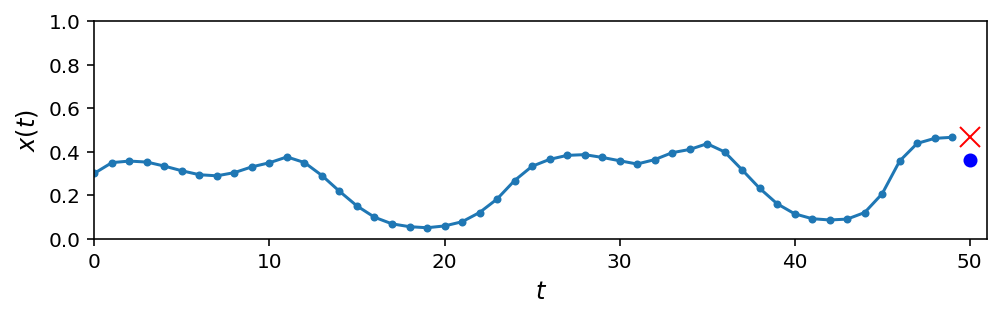

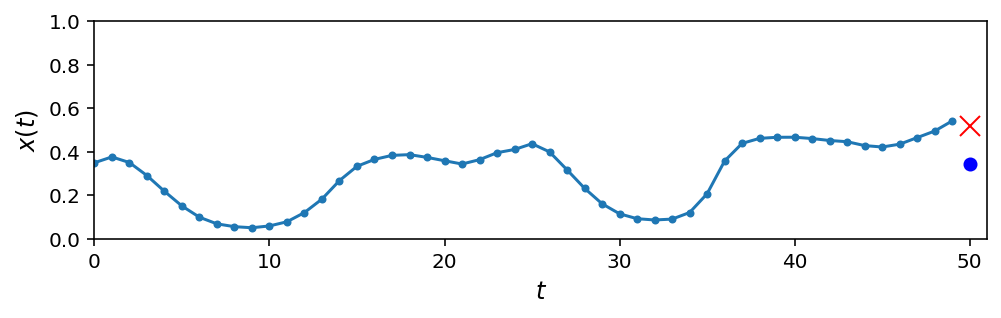

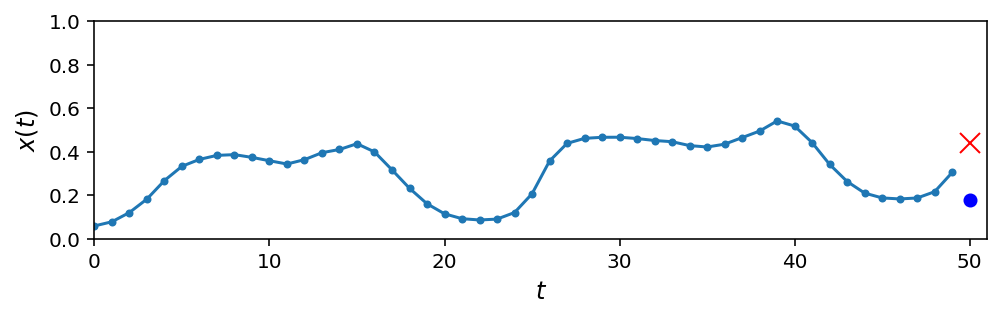

In [35]:
for sample in range(0,30,10):
  plot_series(X_valid[sample, :, 0], y_valid[sample, 0], y_pred[sample, 0])
  plt.show()

## 기본 RNN을 사용하는 모델

In [26]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
624/624 [==============================] - 19s 30ms/step - loss: 0.1039 - val_loss: 0.0539
Epoch 2/10
624/624 [==============================] - 19s 30ms/step - loss: 0.0326 - val_loss: 0.0227
Epoch 3/10
624/624 [==============================] - 19s 30ms/step - loss: 0.0241 - val_loss: 0.0252
Epoch 4/10
624/624 [==============================] - 19s 31ms/step - loss: 0.0237 - val_loss: 0.0297
Epoch 5/10
624/624 [==============================] - 19s 31ms/step - loss: 0.0233 - val_loss: 0.0220
Epoch 6/10
624/624 [==============================] - 19s 31ms/step - loss: 0.0236 - val_loss: 0.0214
Epoch 7/10
624/624 [==============================] - 19s 31ms/step - loss: 0.0235 - val_loss: 0.0276
Epoch 8/10
624/624 [==============================] - 19s 30ms/step - loss: 0.0237 - val_loss: 0.0248
Epoch 9/10
624/624 [==============================] - 19s 30ms/step - loss: 0.0233 - val_loss: 0.0219
Epoch 10/10
624/624 [==============================] - 19s 30ms/step - loss: 0.023

In [27]:
y_pred = model.predict(X_valid)
rmse_r2(y_valid[:,:,0], y_pred)

RMSE = 0.1495
R-Squares = 0.2347


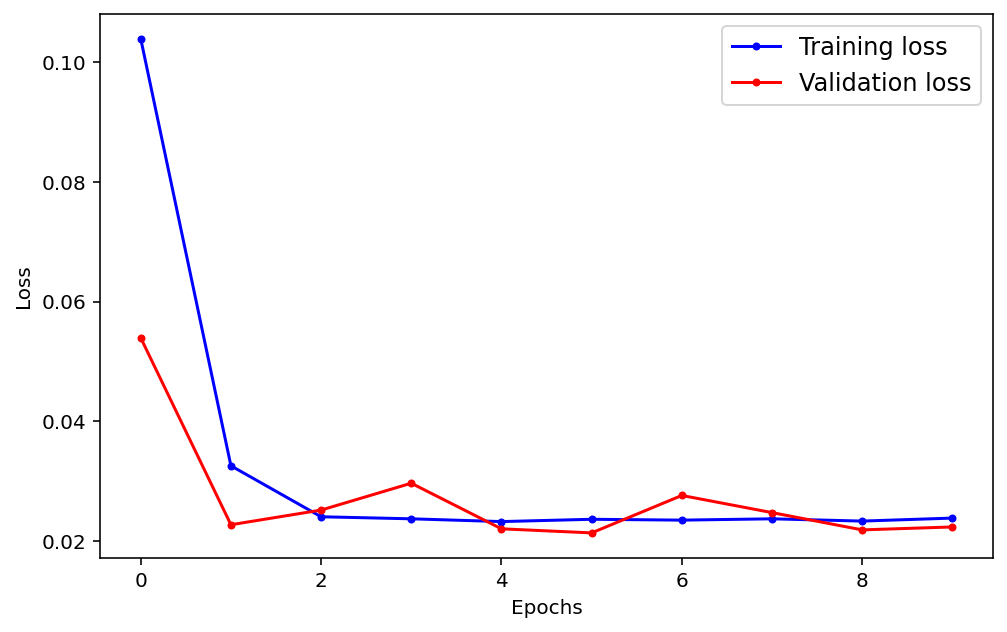

In [28]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

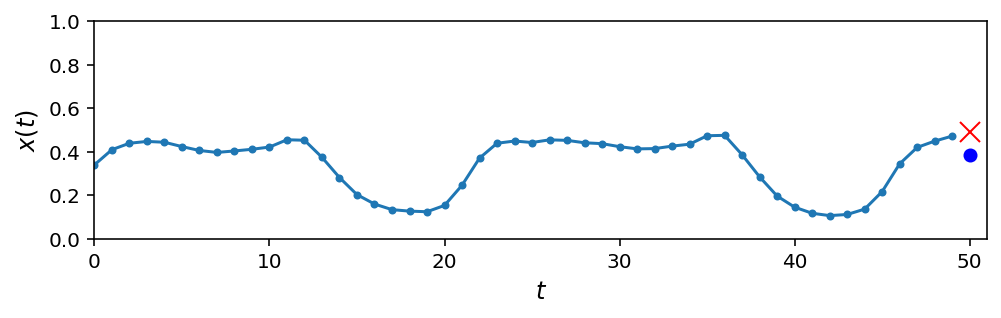

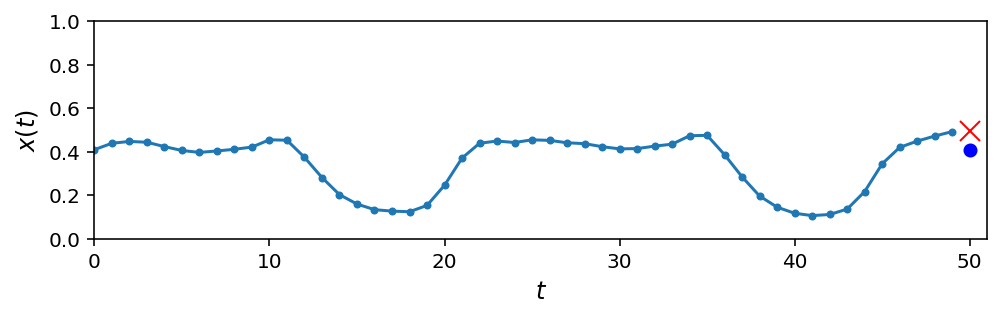

In [29]:
for sample in range(2):
  plot_series(X_valid[sample, :, 0], y_valid[sample, 0], y_pred[sample, 0])
  plt.show()

## 다층 RNN 모델

## 회귀모델이므로 마지막 층에 Dense(1) 사용
- 직전 계층의 return_sequences=True 는 필요없다
- SimpleRNN은 활성화 함수가 tanh이다


In [30]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
624/624 [==============================] - 44s 69ms/step - loss: 0.0052 - val_loss: 8.5637e-04
Epoch 2/10
624/624 [==============================] - 41s 66ms/step - loss: 7.6996e-04 - val_loss: 5.2482e-04
Epoch 3/10
624/624 [==============================] - 41s 66ms/step - loss: 5.0386e-04 - val_loss: 3.2320e-04
Epoch 4/10
624/624 [==============================] - 41s 66ms/step - loss: 3.9055e-04 - val_loss: 5.2902e-04
Epoch 5/10
624/624 [==============================] - 41s 66ms/step - loss: 3.0601e-04 - val_loss: 2.5641e-04
Epoch 6/10
624/624 [==============================] - 41s 66ms/step - loss: 2.7208e-04 - val_loss: 2.8117e-04
Epoch 7/10
624/624 [==============================] - 41s 66ms/step - loss: 2.4430e-04 - val_loss: 1.8404e-04
Epoch 8/10
624/624 [==============================] - 42s 67ms/step - loss: 2.4124e-04 - val_loss: 2.1049e-04
Epoch 9/10
624/624 [==============================] - 41s 66ms/step - loss: 2.2341e-04 - val_loss: 1.8020e-04
Epoch 10/10
62

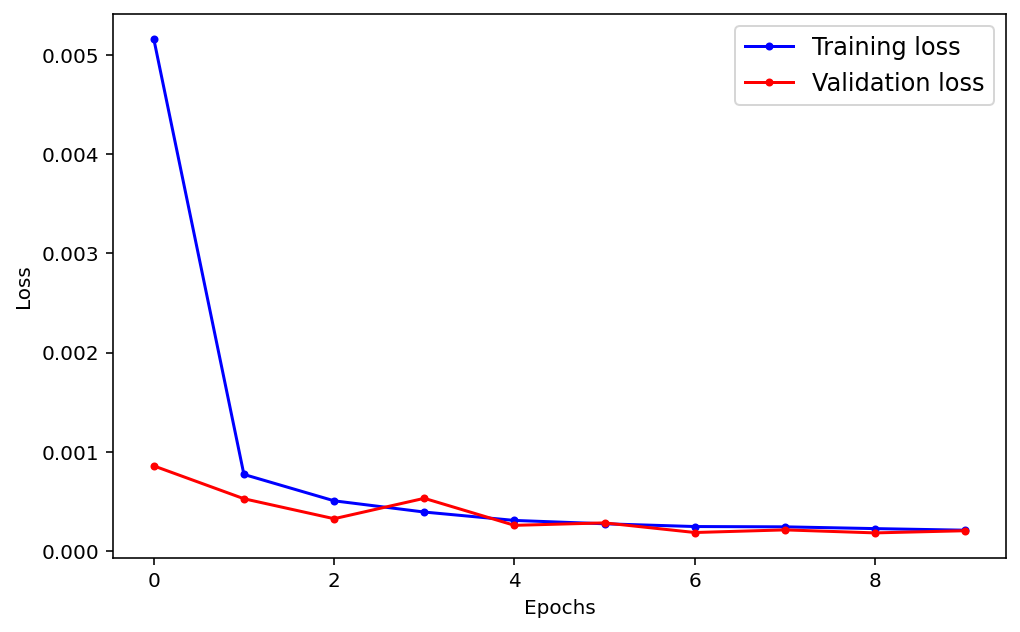

In [31]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [32]:
y_pred = model.predict(X_valid)
rmse_r2(y_valid[:,:,0], y_pred)

RMSE = 0.0142
R-Squares = 0.9931


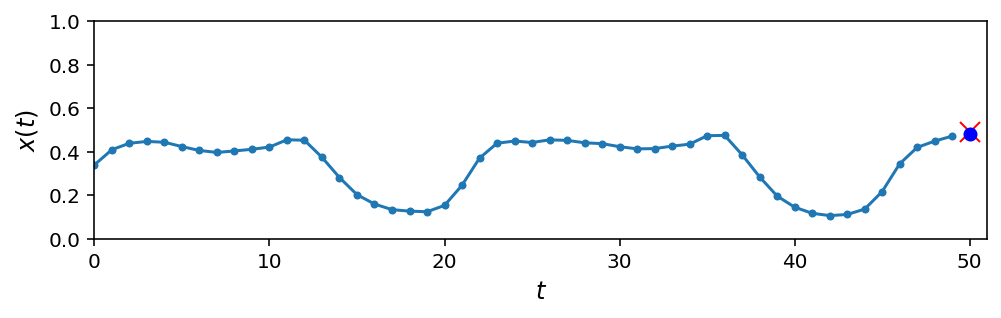

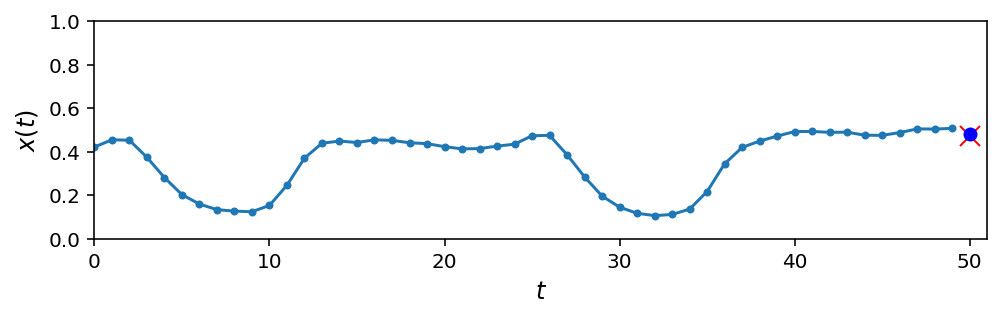

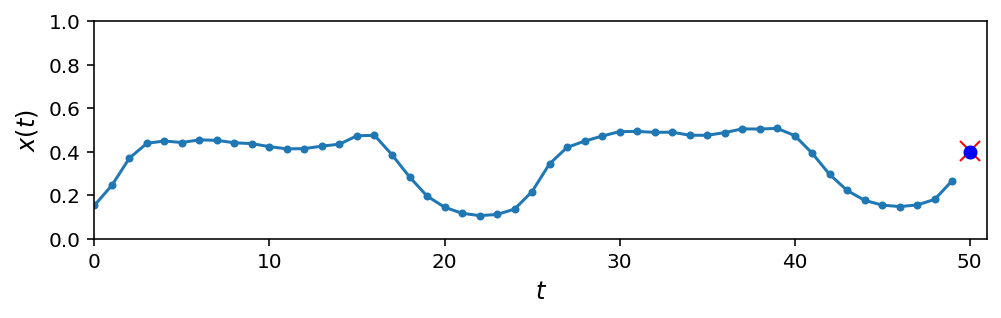

In [33]:
for sample in range(0,30,10):
  plot_series(X_valid[sample, :, 0], y_valid[sample, 0], y_pred[sample, 0])
  plt.show()

# 멀티 스텝 예측
- 먼 미래값 예측

## 미래 10개의 값을 한번에 예측하는 모델 (벡터 출력)
- (1000, 60) 구조의 데이터를 생성

In [34]:
n_steps_in = 50
n_steps_out = 10

X_train, y_train = get_xy(train_sc, n_steps_in, n_steps_out)
X_valid, y_valid = get_xy(test_sc, n_steps_in, n_steps_out)

In [35]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((19941, 50, 1), (19941, 10, 1), (6245, 50, 1), (6245, 10, 1))

In [36]:

cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto')
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=5, # callbacks=[cb],
                    validation_data=(X_valid, y_valid))

Epoch 1/5
624/624 [==============================] - 43s 67ms/step - loss: 0.0167 - val_loss: 0.0046
Epoch 2/5
624/624 [==============================] - 41s 66ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 3/5
624/624 [==============================] - 42s 67ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 4/5
624/624 [==============================] - 42s 67ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 5/5
624/624 [==============================] - 42s 68ms/step - loss: 0.0026 - val_loss: 0.0026


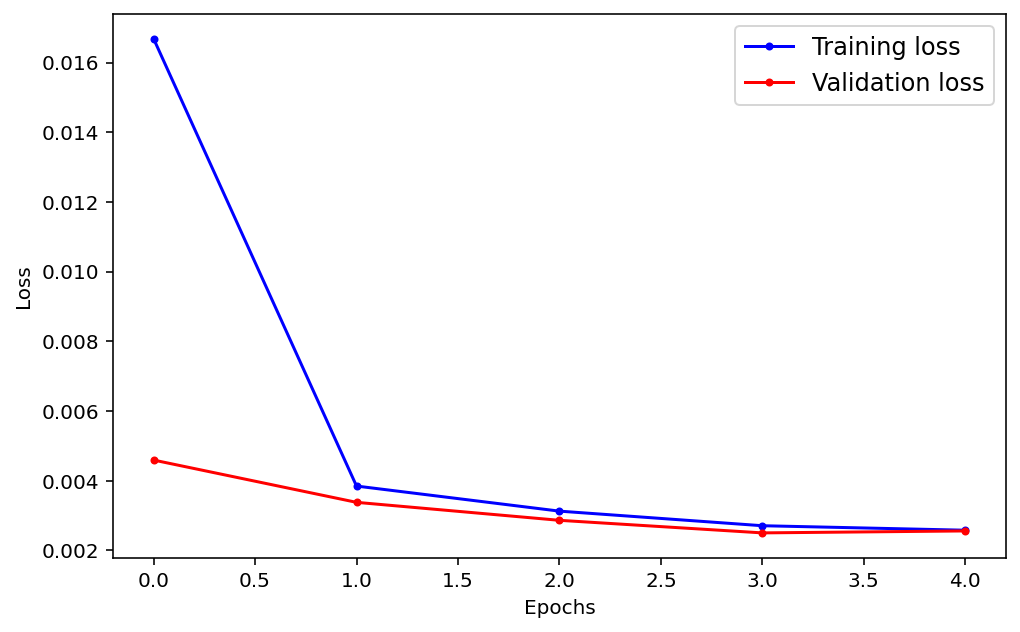

In [37]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## 멀티 예측 그래프 그리기

In [38]:
def plot_multiple_forecasts(sample, X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[sample, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[sample, :], "rx-", label="Actual",markersize=5)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[sample, :], "bo-", label="Forecast",markersize=5)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=12)

RMSE = 0.0506
R-Squares = 0.9125


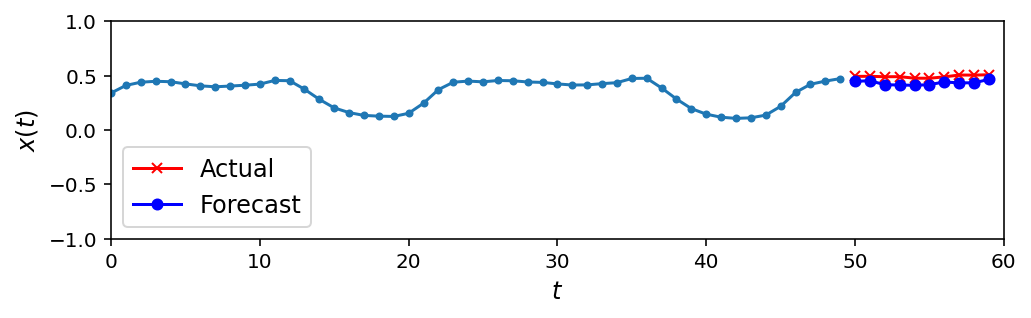

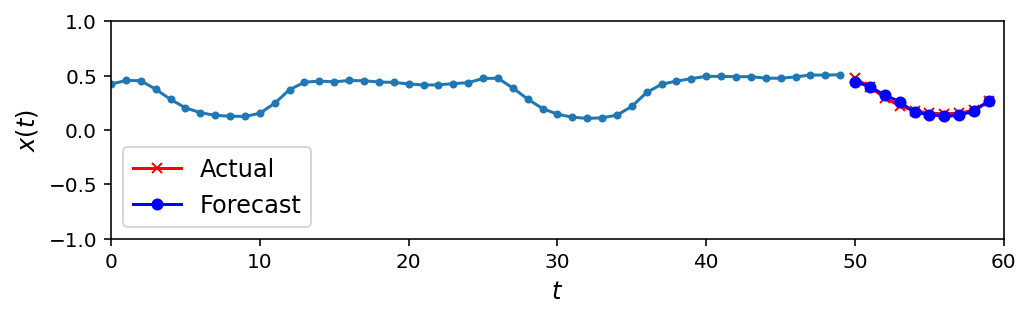

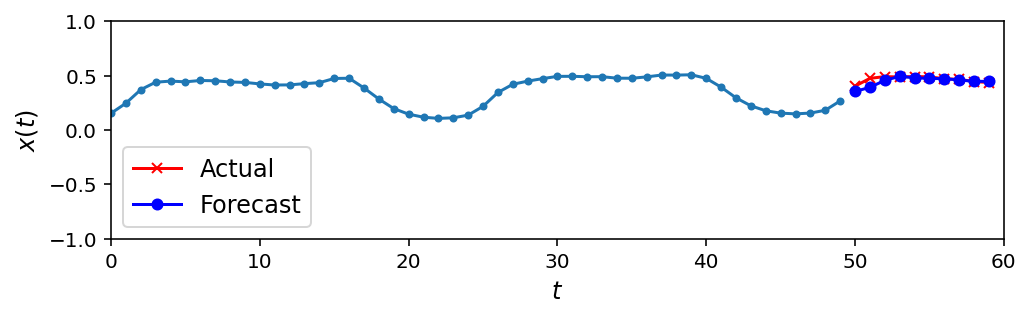

In [39]:
# 테스트 데이터 예측
y_pred = model.predict(X_valid)
rmse_r2(y_valid[:,:,0], y_pred)
for sample in range(0,30,10):
  plot_multiple_forecasts(sample,X_valid, y_valid, y_pred)
  plt.show()

## 시퀀스 투 시퀀스 모델
- 미래의 값을 매 입력시마다 예측하는 모델. 즉, 50 ~ 59 를 예측하기 위해서 0 ~ 49를 한번에 사용하는 것이 아니라,
- 시각 0에는 1 ~ 10를 예측하고 시각 1에는 2 ~ 11 를 예측하는 모델을 만든다.
- 최종적으로 시각 49에서 50 ~ 59 값을 예측한다
- Y_train으로 (700, 10)이 아니라 (700, 50, 10) 구조의 데이터가 필요
- TimeDistributed 층을 사용하여 모든 스텝의 출력값을 최종 Dense()를 구하는데 사용한다
- 성능 평가는 마지막 스텝에서만 평가 (last_time_step_mse)

In [40]:
def get_xy_seq(sequence, n_steps_in, n_seq):
  x, y = [],[]
  for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_seq
    if out_end_ix > len(sequence):
        break
    seq_x = sequence[i:end_ix]
    x.append(seq_x)
    for j in range(n_seq):
      seq_y = sequence[i+1+j:end_ix+1+j]
      y.append(seq_y)
    
  return np.array(x), np.array(y).reshape(-1,n_steps_in,n_seq)

In [41]:
# 4개의 데이터를 보고, 매 스텝마다 2개의 출력을 예측하는 모델
x= np.arange(10)
get_xy_seq(x,4,2)

(array([[0, 1, 2, 3],
        [1, 2, 3, 4],
        [2, 3, 4, 5],
        [3, 4, 5, 6],
        [4, 5, 6, 7]]), array([[[1, 2],
         [3, 4],
         [2, 3],
         [4, 5]],
 
        [[2, 3],
         [4, 5],
         [3, 4],
         [5, 6]],
 
        [[3, 4],
         [5, 6],
         [4, 5],
         [6, 7]],
 
        [[4, 5],
         [6, 7],
         [5, 6],
         [7, 8]],
 
        [[5, 6],
         [7, 8],
         [6, 7],
         [8, 9]]]))

In [42]:
# 실험 데이터 생성, X의 구조는 같다
n_steps = 50
n_steps = 50

X_train, y_train = get_xy_seq(train_sc, n_steps, 10)
X_valid, y_valid = get_xy_seq(test_sc, n_steps, 10)

In [43]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((19941, 50, 1), (19941, 50, 10), (6245, 50, 1), (6245, 50, 10))

In [44]:
cb = tf.keras.callbacks.EarlyStopping(monitor='val-loss', mode='auto')
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, y_train, epochs=3, #callbacks=[cb],
                    validation_data=(X_valid, y_valid))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/3
624/624 [==============================] - 46s 72ms/step - loss: 0.0237 - last_time_step_mse: 0.0250 - val_loss: 0.0130 - val_last_time_step_mse: 0.0117
Epoch 2/3
624/624 [==============================] - 45s 73ms/step - loss: 0.0092 - last_time_step_mse: 0.0060 - val_loss: 0.0075 - val_last_time_step_mse: 0.0042
Epoch 3/3
624/624 [==============================] - 44s 71ms/step - loss: 0.0075 - last_time_step_mse: 0.0046 - val_loss: 0.0068 - val_last_time_step_mse: 0.0038


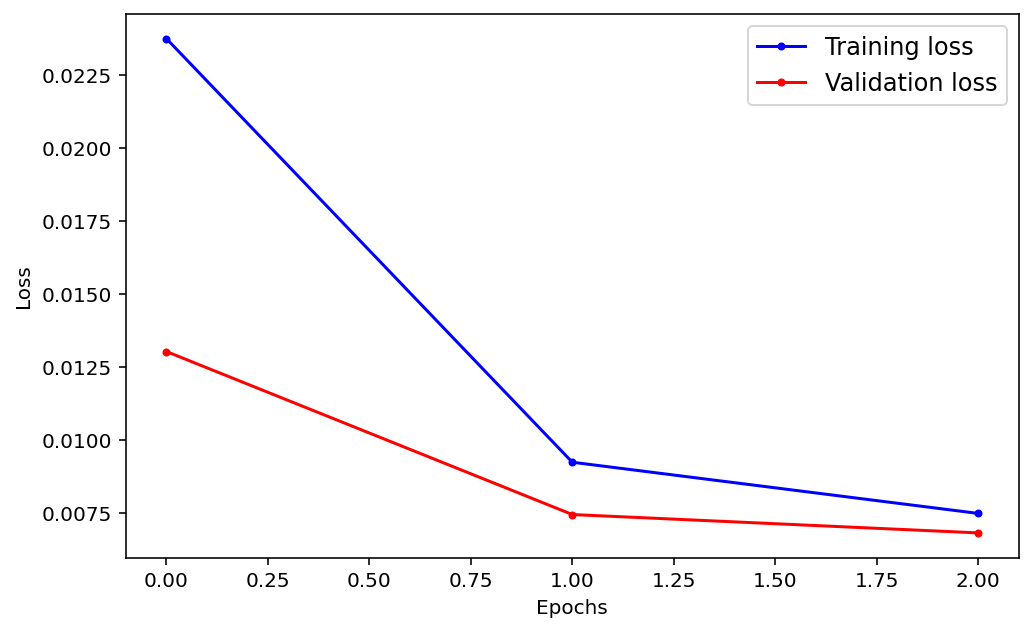

In [45]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

RMSE = 0.062
R-Squares = 0.8686


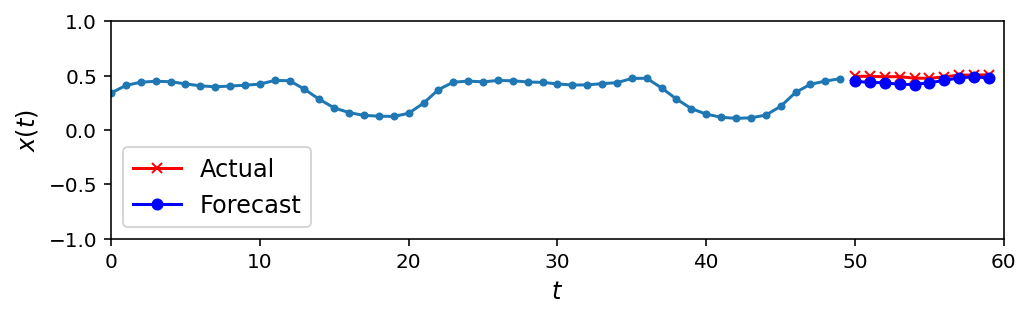

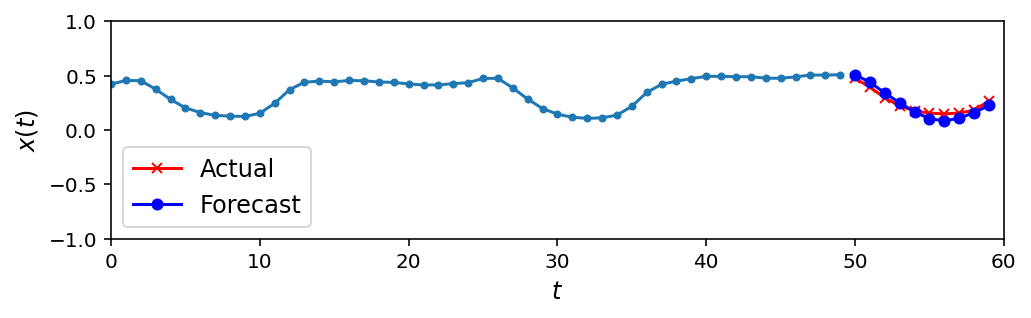

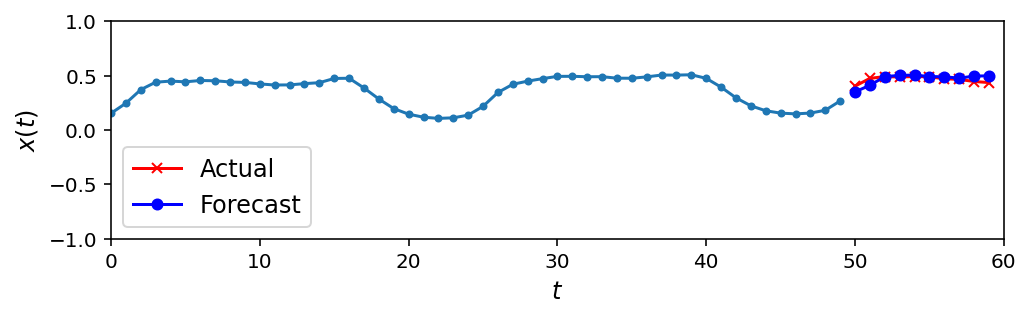

In [46]:
# 성능평가 (마지막 스텝의 출력만 사용한다)
# Y_pred = model.predict(X_valid) # 이것이 아님!
y_pred = model.predict(X_valid)[:, -1]
rmse_r2(y_valid[:, -1], y_pred)

for sample in range(0,30,10):
  plot_multiple_forecasts(sample,X_valid, y_valid[:, -1], y_pred)
  plt.show()

## 배치 정규화
- 성능 개선을 위해서 시도

In [47]:
# model = keras.models.Sequential([
#     keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
#     keras.layers.BatchNormalization(),
#     keras.layers.SimpleRNN(20, return_sequences=True),
#     keras.layers.BatchNormalization(),
#     keras.layers.TimeDistributed(keras.layers.Dense(10))
# ])

# model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20,
#                     validation_data=(X_valid, Y_valid))

# LSTM
- RNN의 성능 개선

In [49]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_valid, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
624/624 [==============================] - 7s 8ms/step - loss: 0.0328 - last_time_step_mse: 0.0309 - val_loss: 0.0256 - val_last_time_step_mse: 0.0256
Epoch 2/10
624/624 [==============================] - 5s 7ms/step - loss: 0.0248 - last_time_step_mse: 0.0244 - val_loss: 0.0248 - val_last_time_step_mse: 0.0241
Epoch 3/10
624/624 [==============================] - 5s 7ms/step - loss: 0.0244 - last_time_step_mse: 0.0232 - val_loss: 0.0248 - val_last_time_step_mse: 0.0232
Epoch 4/10
624/624 [==============================] - 5s 7ms/step - loss: 0.0242 - last_time_step_mse: 0.0224 - val_loss: 0.0246 - val_last_time_step_mse: 0.0227
Epoch 5/10
624/624 [==============================] - 5s 7ms/step - loss: 0.0242 - last_time_step_mse: 0.0223 - val_loss: 0.0245 - val_last_time_step_mse: 0.0228
Epoch 6/10
624/624 [==============================] - 5s 7ms/step - loss: 0.0241 - last_time_step_mse: 0.0223 - val_loss: 0.0245 - val_last_time_step_mse: 0.0231
Epoch 7/10
624/624 [========

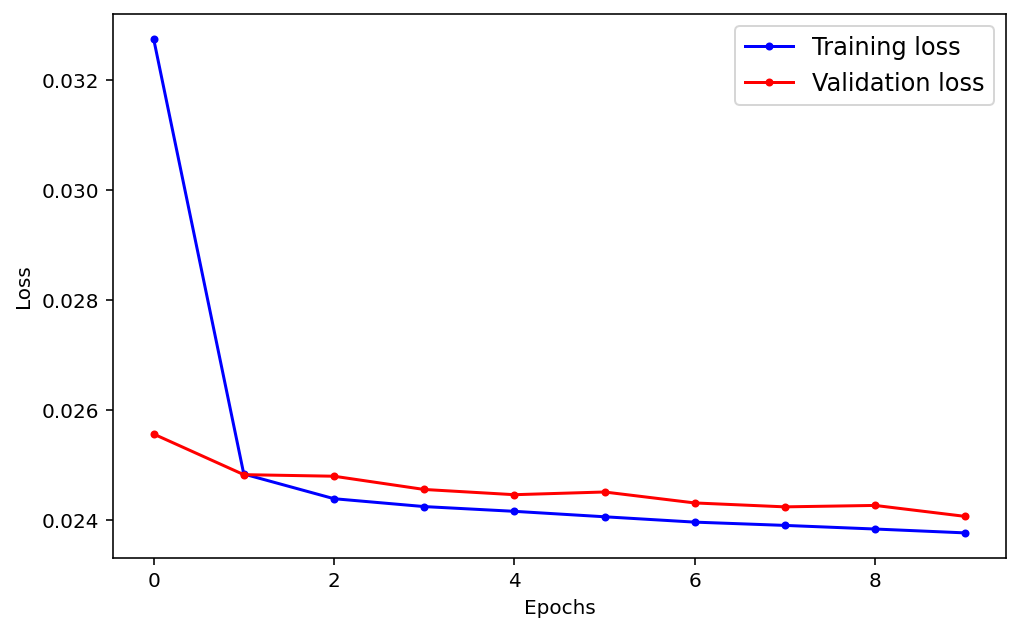

In [50]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

RMSE = 0.1502
R-Squares = 0.2285


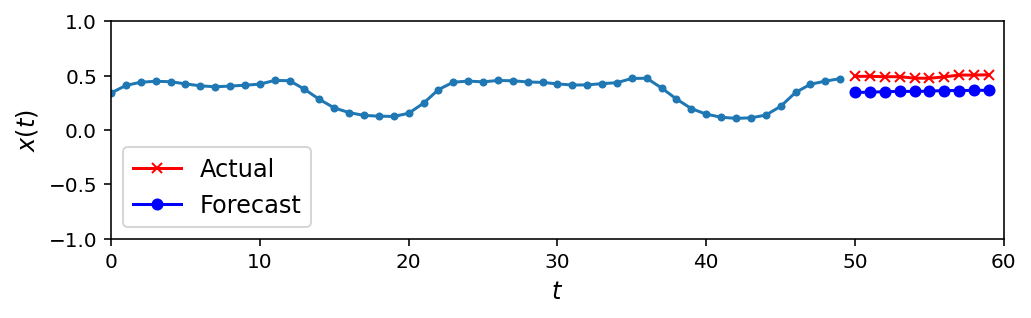

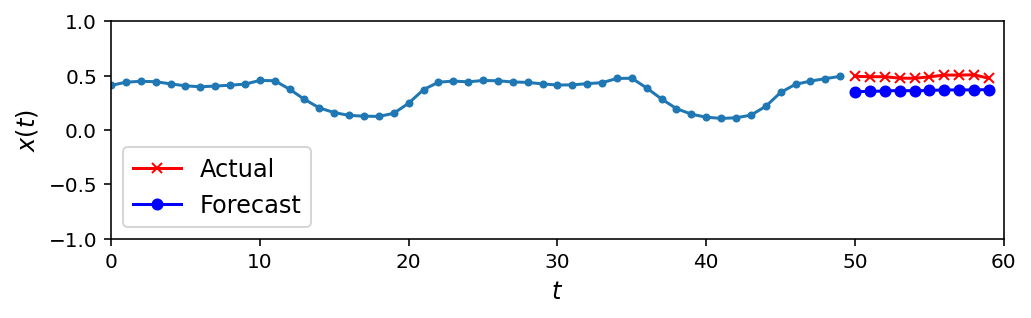

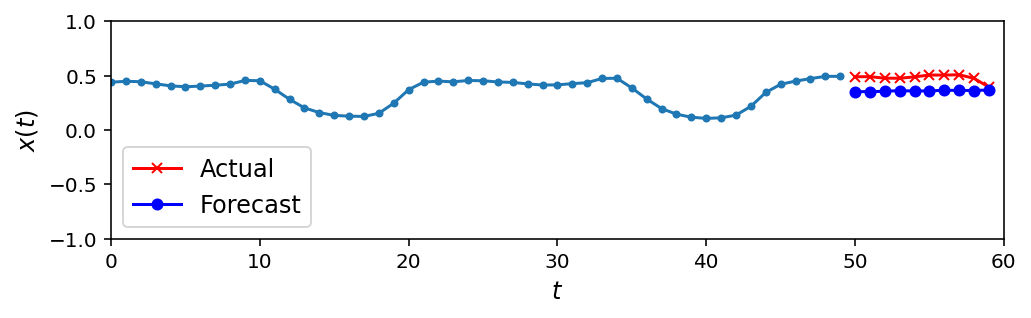

In [52]:
y_pred = model.predict(X_valid)[:, -1]
rmse_r2(y_valid[:, -1], y_pred)

for sample in range(3):
  plot_multiple_forecasts(sample,X_valid, y_valid[:, -1], y_pred)
  plt.show()

# GRU
- LSTM과 성능은 유사하면서 계산량 감소

In [54]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_valid, y_valid, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
196/196 [==============================] - 31s 12ms/step - loss: 0.0435 - last_time_step_mse: 0.0447 - val_loss: 0.0287 - val_last_time_step_mse: 0.0297
Epoch 2/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0275 - last_time_step_mse: 0.0289 - val_loss: 0.0257 - val_last_time_step_mse: 0.0271
Epoch 3/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0253 - last_time_step_mse: 0.0262 - val_loss: 0.0251 - val_last_time_step_mse: 0.0258
Epoch 4/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0249 - last_time_step_mse: 0.0258 - val_loss: 0.0249 - val_last_time_step_mse: 0.0257
Epoch 5/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0248 - last_time_step_mse: 0.0255 - val_loss: 0.0248 - val_last_time_step_mse: 0.0254
Epoch 6/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0247 - last_time_step_mse: 0.0252 - val_loss: 0.0247 - val_last_time_step_mse: 0.0251
Epoch 7/10
196/196 [======

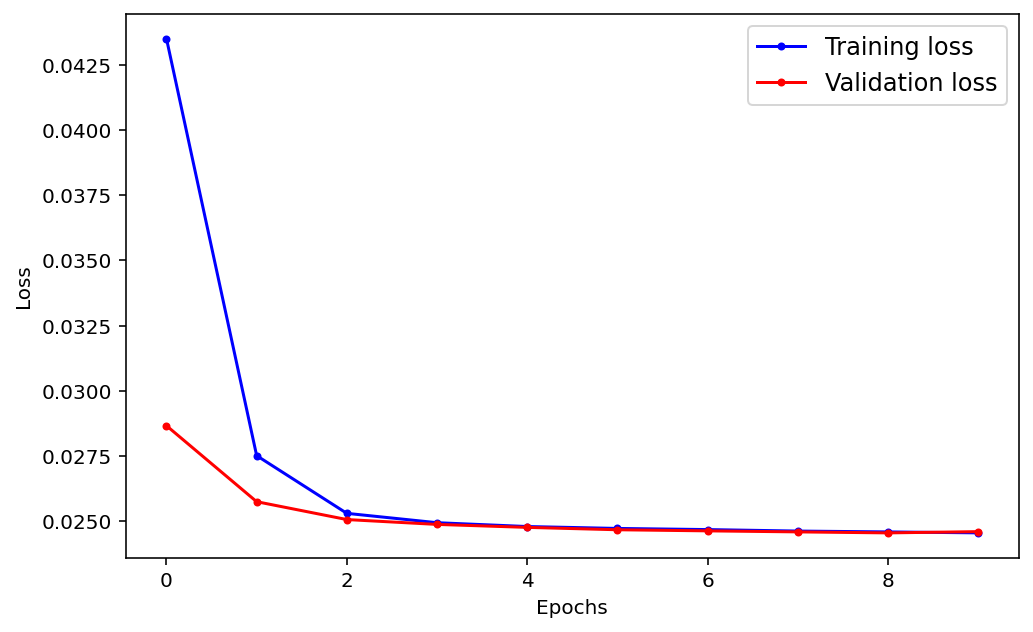

In [55]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

RMSE = 0.1562
R-Squares = 0.1654


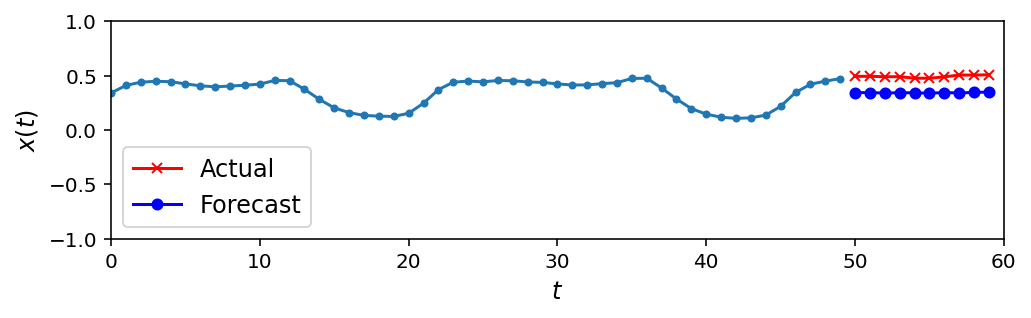

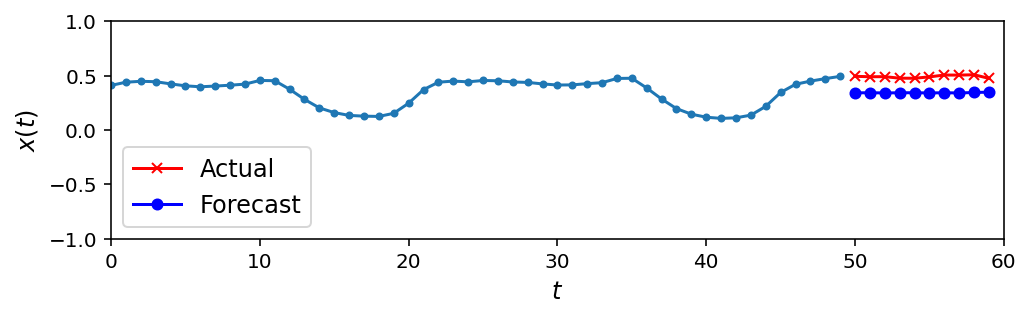

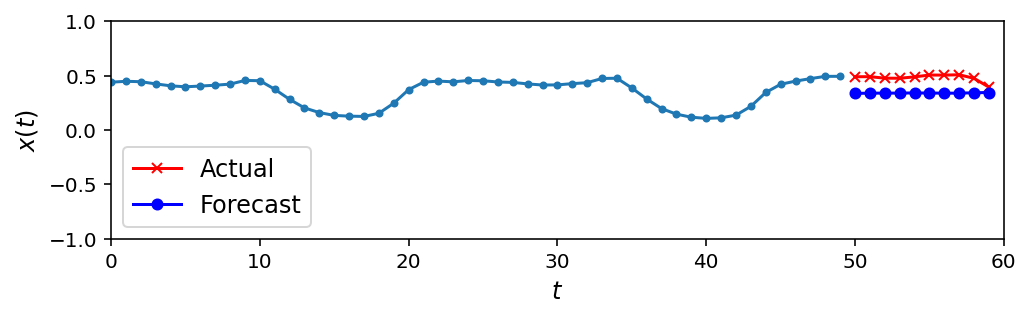

In [57]:
y_pred = model.predict(X_valid)[:, -1]
rmse_r2(y_valid[:, -1], y_pred)
for sample in range(3):
  plot_multiple_forecasts(sample,X_valid, y_valid[:, -1], y_pred)
  plt.show()

## 1D Convolutional 을 사용하여 긴 시퀀스를 압축하기
- kernel, stride 고려
- valid 사용

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [58]:
import numpy as np
x = np.arange(20)
x[5::2]

array([ 5,  7,  9, 11, 13, 15, 17, 19])

In [59]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=6, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_valid, y_valid[:, 5::2], epochs=20,
                    validation_data=(X_valid, y_valid[:, 5::2]))

Epoch 1/20
196/196 [==============================] - 30s 10ms/step - loss: 0.0398 - last_time_step_mse: 0.0417 - val_loss: 0.0273 - val_last_time_step_mse: 0.0308
Epoch 2/20
196/196 [==============================] - 1s 7ms/step - loss: 0.0255 - last_time_step_mse: 0.0275 - val_loss: 0.0244 - val_last_time_step_mse: 0.0251
Epoch 3/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0242 - last_time_step_mse: 0.0247 - val_loss: 0.0241 - val_last_time_step_mse: 0.0248
Epoch 4/20
196/196 [==============================] - 1s 8ms/step - loss: 0.0239 - last_time_step_mse: 0.0243 - val_loss: 0.0239 - val_last_time_step_mse: 0.0243
Epoch 5/20
196/196 [==============================] - 2s 8ms/step - loss: 0.0237 - last_time_step_mse: 0.0240 - val_loss: 0.0235 - val_last_time_step_mse: 0.0240
Epoch 6/20
196/196 [==============================] - 1s 8ms/step - loss: 0.0233 - last_time_step_mse: 0.0236 - val_loss: 0.0229 - val_last_time_step_mse: 0.0232
Epoch 7/20
196/196 [======

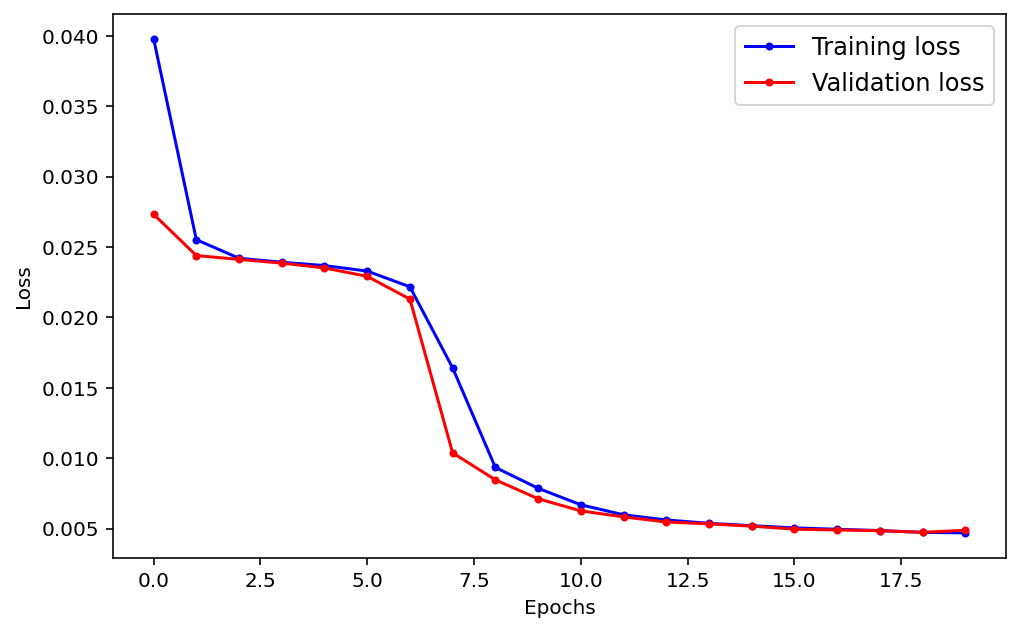

In [60]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

RMSE = 0.0633
R-Squares = 0.8628


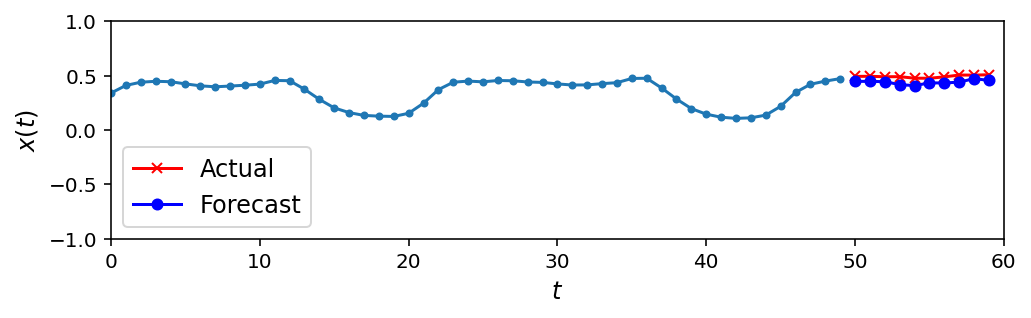

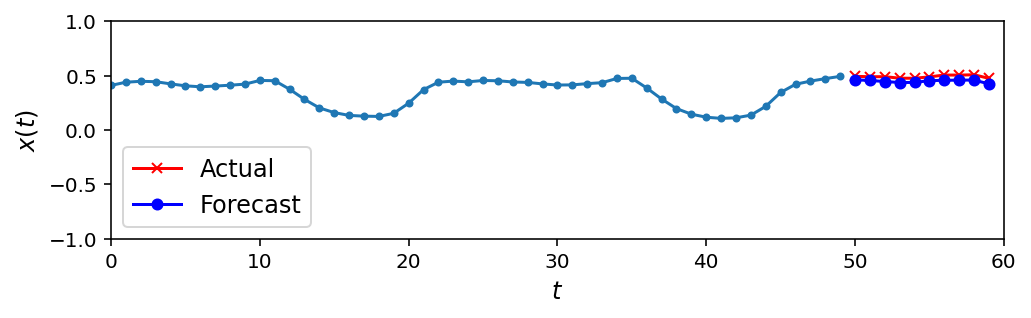

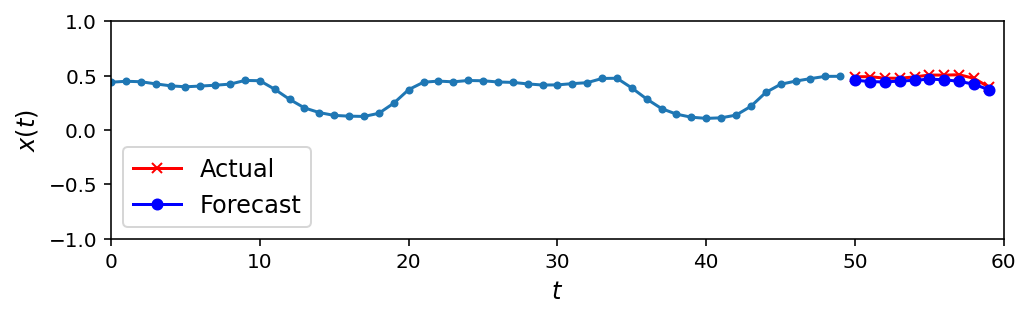

In [62]:
y_pred = model.predict(X_valid)[:, -1]
rmse_r2(y_valid[:, -1], y_pred)
for sample in range(3):
  plot_multiple_forecasts(sample,X_valid, y_valid[:, -1], y_pred)
  plt.show()